In [3]:
from matplotlib import pyplot as plt, animation
import numpy as np
import requests
import os

%matplotlib notebook

# Zadatak 9

*[Link na zadatak]()*

In [4]:
def get_aoc_input(session_str, day, year):
    
    if os.path.exists('./input.txt'):
        with open('input.txt', r) as f:
            text = f.readline()
        return text
    else:
        response = requests.get(
            f'https://adventofcode.com/{year}/day/{day}/input',
            headers={'cookie':f'session={session_str}'}
        )
    
        try:
            with open('input.txt', 'w') as f:
                f.write(response.text)
            return response.text
        except Exception as e:
            print(f'Error: {e.args}')
            return None

In [5]:
def part2(inlist, low):
    basins = []
    for (xx,yy) in low:
        seen = set()
        Q = [(xx,yy)]
        points = []
        temp = []
        while len(Q) > 0:
            curr = Q.pop(0)
            x,y = curr
            if curr in seen: continue
            seen.add(curr)
            if y < 0 or y > len(inlist) - 1 or x < 0 or x > len(inlist[0]) - 1: continue
            if int(inlist[y][x]) == 9: continue
            if len(points) == 0:
                points.append(int(inlist[y][x]))
                temp.append((y,x))
            else:
                if int(inlist[y][x]) != 9:
                    points.append(int(inlist[y][x]))
            Q+= [(x+1,y), (x-1,y), (x,y+1), (x,y-1)]
        basins.append(len(points))
    basins.sort()
    print(f'Size of the largest three basins: {basins[-1]}, {basins[-2]}, {basins[-3]}')
    print(f'Those numbers multiplied: {basins[-1] * basins[-2] * basins[-3]}')


In [6]:
def part1(inlist, matrix, low):
    s = 0
    for j,line in enumerate(inlist):
        for i,l in enumerate(line):
            ok = True
            for x in [-1,0,1]:
                for y in [-1,0,1]:
                    if x * y == 0 and x != y and -1 < y + j < len(inlist) and -1 < x + i < len(line):
                        ok &= int(inlist[y+j][x+i]) > int(l)
            if ok:
                s += 1+int(l)
                low.append((i,j))
                matrix[j][i] = 0
                yield matrix
            else:
                matrix[j][i] = 6 if matrix[j][i] != 9 else 9
    print(f'Number of low points: {s}')

Number of low points: 439


<IPython.core.display.Javascript object>


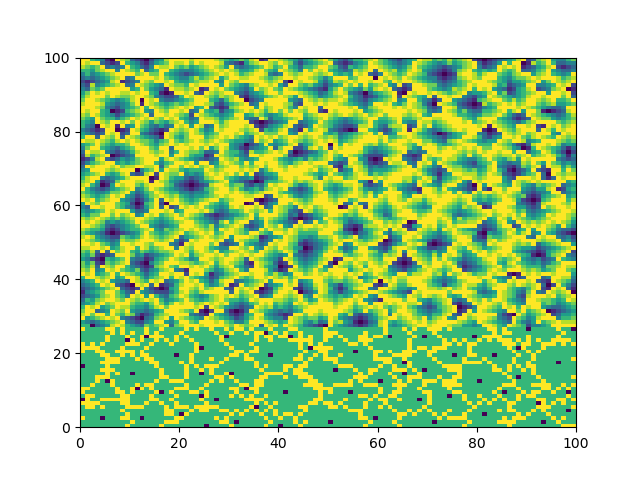

Size of the largest three basins: 100, 99, 91
Those numbers multiplied: 900900


In [7]:
inlist = [x.strip() for x in open('input').readlines()]
low = []
matrix = [[int(x) for x in line] for line in inlist]
matrixes = np.array([[[int(x) for x in line] for line in inlist]])

for m in part1(inlist, matrix, low):
    matrixes = np.append(matrixes, [m], axis=0)
    
fig, ax = plt.subplots()
cax = ax.pcolormesh(matrixes[0, :, :])

part2(inlist, low)

In [8]:
def animate(i):
    cax.set_array(matrixes[i, :, :])
    return cax

anim = animation.FuncAnimation(fig, animate, interval=100, frames=matrixes.shape[0] - 1)
plt.show()